In [1]:
import psycopg2 as pg
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
from fancyimpute import IterativeImputer, KNN
from sklearn.model_selection import train_test_split
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline
import scipy.stats as scs
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from visualize import generate_moons_df, preprocess, plot_boundaries
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, classification_report
import xgboost as xgb


from sklearn import metrics

## Import data from SQL
Reference to data: Soil erosion and organic matter variations for central great plains cropping systems under residue removal (2015) - R. G. Nelson, J. Tatarko, J. C. Ascough II. 

Simulated data for various soil erosion, organic residue, and crop parameters were obtained. Author's mentioned that the tools and models used to simulate data is the best and most reliable in the field, therefore the data is extremely similar to real-life conditions.

In [ ]:
#connect with SQL server with psycopg2
connection_args = {'host':'localhost',
               'dbname':'project3',
               'port': 5432}
connection = pg.connect(**connection_args)

In [7]:
#earlier step: used pgadmin4 to import and concatenate 6 CSVs together to make a final df
#make a query to grab the dataset
#complete SQL challenge 9 in order to fulfill SQL requirement
query = 'SELECT * FROM final_df'
df = pd.read_sql(query, connection)

df.head()

,areasymbol,CoFIPS,mukey,musym,muname,muacres,comppct_r,tfact,nirrcapcl,nirrcapscl,...,sciom,scier,scifo,Slope,removal,Rem_Res_ann_avg,crop1,Rem_Res-_crop1,crop2,Rem_Res_crop2
0,CO001,1,94035,AaB,"Adena loam, 0 to 3 percent slopes",17461,87,5,4,e,...,1.32,1,0.97,2,NRH,0,None,None,None,None
1,CO001,1,94035,AaB,"Adena loam, 0 to 3 percent slopes",17461,87,5,4,e,...,0.22,0.98,0.96,2,MHH,"4,327.80",CG,"4,327.80",None,None
2,CO001,1,94035,AaB,"Adena loam, 0 to 3 percent slopes",17461,87,5,4,e,...,1.04,0.97,0.27,2,NRH,0,None,None,None,None
3,CO001,1,94035,AaB,"Adena loam, 0 to 3 percent slopes",17461,87,5,4,e,...,0.22,0.94,0.25,2,MHH,"3,787.50",CG,"3,787.50",None,None
4,CO001,1,94035,AaB,"Adena loam, 0 to 3 percent slopes",17461,87,5,4,e,...,0.71,0.99,0.97,2,NRH,0,None,None,None,None


## Clean up code

The values were given in string format, therefore "NULL's had to be given a None value in order for it to be registered as a missing value. The values then had to be changed to numerical format. Finally, the number of missing values and unique values were examined.

In [9]:
#remove columns that are not useful
#df= df.drop(['irracpcl','irracpscl','crop2','Rem_Res_crop2'], axis = 1, inplace = True)
df.drop(df.tail(1).index,inplace=True)
#change "Null" to None
for (columnNames, columnData) in df.iteritems():
    df[columnNames].replace({'NULL':None}, inplace = True)

#numerical data is in string format, change to numeric data type
for (columnNames, columnData) in df.iteritems():
    try:
        df[columnNames] = pd.to_numeric(df[columnNames])
    except ValueError:
        pass
#examine the number of null and unique values in the df    
for (columnName, columnData) in df.iteritems():
    print('There are {} null values in the {} column. There are {} unique values.' .format(df[columnName].isnull().sum(), columnName, len(df[columnName].unique())))

There are 0 null values in the areasymbol column. There are 233 unique values.
There are 0 null values in the CoFIPS column. There are 139 unique values.
There are 0 null values in the mukey column. There are 13104 unique values.
There are 0 null values in the musym column. There are 4108 unique values.
There are 0 null values in the muname column. There are 6208 unique values.
There are 0 null values in the muacres column. There are 9531 unique values.
There are 0 null values in the comppct_r column. There are 75 unique values.
There are 0 null values in the tfact column. There are 5 unique values.
There are 204 null values in the nirrcapcl column. There are 9 unique values.
There are 5488 null values in the nirrcapscl column. There are 5 unique values.
There are 123208 null values in the irracpcl column. There are 8 unique values.
There are 135932 null values in the irracpscl column. There are 5 unique values.
There are 500 null values in the farmlndcl column. There are 13 unique val

### Key to what the variables mean
Obtained from the description.csv that came along with the dataset.
- mukey: SSURGO Metadata - A non-connotative string of characters used to uniquely identify a record in the Mapunit table.
- musym: SSURGO Metadata - The symbol used to uniquely identify the soil mapunit in the soil survey.
- muname: SSURGO Metadata - Correlated name of the mapunit (recommended name or field name for surveys in progress).
- muacres: SSURGO Metadata - The number of acres of a particular mapunit.
- comppct_r: SSURGO Metadata - The percentage of the component of the mapunit.
- tfact SSURGO: Metadata - Soil loss tolerance factor. The maximum amount of erosion at which the quality of a soil as a medium for plant growth can be maintained.
- nirrcapcl: SSURGO Metadata - The broadest category in the land capability classification system for nonirrigated soils.
- nirrcapscl: SSURGO Metadata - The second category in the land capability classification system for nonirrigated soils.
- farmlndcl: SSURGO Metadata - Identification of map units as prime farmland, farmland of statewide importance, or farmland of local importance.
- awc_r: SSURGO Metadata - The amount of water that an increment of soil depth, inclusive of fragments, can store that is available to plants. AWC is expressed as a volume fraction, and is commonly estimated as the difference between the water contents at 1/10 or 1/3 bar (field capacity) and 15 bars (permanent wilting point) tension and adjusted for salinity, and fragments.
- texdesc: SSURGO Metadata - The full texture description for a horizon, using full texture class and in lieu of names rather than abbreviations.
- texture: SSURGO Metadata - Name for the concatenation of TEXTURE_MODIFIER and TEXTURE_CLASS.
- rotation: The crop rotation where each crop/management period is represented by a two character identifier.  See Nelson et al, 2014 for a more detailed description.
- yield1: Average yield for the first year of the rotation.  See Nelson et al, 2014 for yield units for each crop.
- yield2: Yield for the second year of the rotation.  "NULL" indicates there was not crop that year.  See Nelson et al, 2014 for yield units for each crop.
- yield3: Yield for the third year of the rotation.  "NULL" indicates there was not crop that year.  See Nelson et al, 2014 for yield units for each crop.
- tillage: Tillage system designation where NT = no-till and RT = reduced till
- soil erosion: Total combined wind and water erosion (T/Acre/Yr).
- watereros: Total water erosion (T/Acre/Yr).
- winderos: Total wind erosion (T/Acre/Yr).
- sci: Soil Conditioning Index.
- sciom: Organic Matter component of the Soil Conditioning Index.
- scier: Erosion component of the Soil Conditioning Index.
- scifo: Field Operation component of the Soil Conditioning Index.
- Slope	SSURGO Metadata	Average field slope (SSURGO value Slope_r)
- removal: Residue removel level where MHH = Moderate high harvest (50% residue removal) and NRH = No residue removal (0% residue removal).
- Rem Res - ann avg: Average crop residue over the three year rotation period (kg/ha).
- crop1: Crop in year 1 of the three year rotation.
- Rem Res - crop1: Amount of residue sustainably removable in year 1 of the rotation  (kg/ha).  

There are a total of 74,423 rows of missing data. If crop1 and Rem_res_crop1 feature was ignored, we have around 148,847 rows. That's a large proportion of data compared to the original 260K row data set.

Note: There are several columns in the data set that has the target variable in them. Those include: winderos, watereros, sci, and possibly soil tolerance factor.

Next: Soil texture description provide valuable information the soil type of that area. However, there are 96 unique descriptions but only 13 soil classes as defined by the USDA. Therefore, using the USDA classification, the soil texture descriptions will be lumped into their respective classes. The sequence of "loam", "sand", "clay", and "silt" in the description determines which class it would be classified into. For example, "very fine sandy loam" will be classified into "sandy loam" instead of "loamy sand". 

In [14]:
#will need to recategorize some of these
counts = df['texdesc'].value_counts().to_dict()
counts

{'silt loam': 48388,
 'loam': 47924,
 'fine sandy loam': 39200,
 'clay loam': 25432,
 'loamy fine sand': 18580,
 'silty clay loam': 14244,
 'sandy loam': 11212,
 'fine sand': 10436,
 'clay': 8440,
 'loamy sand': 7096,
 'very fine sandy loam': 6580,
 'loamy very fine sand': 3040,
 'silty clay': 2908,
 'gravelly loam': 2216,
 'slightly decomposed plant material': 2184,
 'sand': 1796,
 'gravelly sandy loam': 1340,
 'moderately decomposed plant material': 1064,
 'gravelly fine sandy loam': 640,
 'sandy clay loam': 584,
 'very gravelly sandy loam': 460,
 'gravelly clay loam': 388,
 'stony fine sandy loam': 364,
 'cobbly loam': 344,
 'stony clay': 332,
 'stony loam': 304,
 'stony clay loam': 288,
 'very cobbly loam': 272,
 'cobbly clay loam': 212,
 'very cobbly fine sandy loam': 176,
 'very stony loam': 176,
 'channery loam': 164,
 'loamy coarse sand': 156,
 'very gravelly loam': 152,
 'extremely stony loam': 128,
 'stony sandy loam': 128,
 'coarse sand': 120,
 'very cobbly sandy loam': 112,

In [15]:
new_categories = {'sand':['fine sand','sand','coarse sand', 'gravelly sand','gravelly coarse sand'],
                  'loamy sand':['loamy fine sand', 'loamy sand','loamy very fine sand', 'loamy coarse sand',
                                'gravelly loamy sand','stony loamy fine sand','gravelly loamy fine sand', 'very gravelly loamy sand',
                                'extremely gravelly loamy sand','stratified loamy fine sand'],
                  'sandy loam':['fine sandy loam', 'sandy loam', 'very fine sandy loam','gravelly sandy loam','gravelly fine sandy loam',
                                'very gravelly sandy loam','stony fine sandy loam','very cobbly fine sandy loam','stony sandy loam',
                                'very cobbly sandy loam','coarse sandy loam','cobbly fine sandy loam','very stony fine sandy loam',
                                'channery very fine sandy loam', 'stratified very fine sandy loam','very gravelly coarse sandy loam',
                                'extremely stony fine sandy loam','very stony sandy loam','stratified fine sandy loam to silt loam to silty clay loam',
                                'cobbly sandy loam','gravelly very fine sandy loam','flaggy fine sandy loam','stratified fine sandy loam',
                                'extremely bouldery fine sandy loam','channery sandy loam','very gravelly fine sandy loam','variable'],
                  'loam':['loam','cobbly loam','stony loam','gravelly loam','very cobbly loam','channery loam','stratified loam','very gravelly loam',
                          'extremely stony loam','very channery loam','extremely cobbly loam','flaggy loam','very flaggy loam'],
                  'silty loam':['silt loam','gravelly silt loam','cobbly silt loam','stratified silt loam','flaggy silt loam','channery silt loam',
                                'stony silt loam','extremely gravelly silt loam'],
                  'clay loam':['clay loam','sandy clay loam','gravelly clay loam','stony clay loam','cobbly clay loam','very stony clay loam',
                               'very gravelly clay loam','very cobbly clay loam','channery clay loam','very channery clay loam','extremely stony clay loam',
                               'flaggy clay loam'],
                  'silty clay loam':['silty clay loam','gravelly silty clay loam','channery silty clay loam','stony silty clay loam',
                                     'extremely stony silty clay loam','very flaggy silty clay loam'],
                  'silty clay':['silty clay','stony silty clay','cobbly silty clay'],
                  'clay':['clay','stony clay','very stony clay','cobbly clay','very cobbly clay','bouldery clay'],
                  'decomposed plant material':['slightly decomposed plant material','moderately decomposed plant material','mucky peat','peat']}
categories = {v:k for k,vv in new_categories.items() for v in vv}
df['soil_text'] = df['texdesc'].map(categories)
                  

In [17]:
counts = df['soil_text'].value_counts().to_dict()
counts

{'sandy loam': 60840,
 'loam': 51680,
 'silty loam': 48740,
 'loamy sand': 29132,
 'clay loam': 27312,
 'silty clay loam': 14412,
 'sand': 12420,
 'clay': 8964,
 'decomposed plant material': 3360,
 'silty clay': 2996}

#### Graph to check the distribution of soil classes

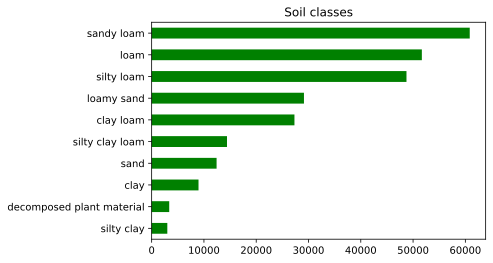

In [18]:
df_soil_class = df['soil_text'].value_counts()
bar_plot = df_soil_class.plot(kind = 'barh', title = 'Soil classes',color = 'green')
bar_plot.invert_yaxis()

#### Imputing columns that have greater than 50000 values (nearly 20% of the data) may throw of modeling. Initially, work with data that have very little missing values and come back to imputation if the modeling is accurate.

In [21]:
#drop columsn that have too many null values
for (columnName, columnData) in df.iteritems():
    sum_null = df[columnName].isnull().sum()
    if sum_null > 50000:
        df.drop([columnName], inplace = True, axis = 1)
df.columns

Index(['areasymbol', 'CoFIPS', 'mukey', 'musym', 'muname', 'muacres',
       'comppct_r', 'tfact', 'nirrcapcl', 'nirrcapscl', 'farmlndcl', 'awc_r',
       'texdesc', 'texture', 'rotation', 'yield1', 'tillage', 'soil_erosion',
       'watereros', 'winderos', 'sci', 'sciom', 'scier', 'scifo', 'Slope',
       'removal', 'Rem_Res_ann_avg', 'soil_text'],
      dtype='object')

In [ ]:
#Save to a csv file
#df.to_csv('cleaned_df.csv')

#### Correlation plot shows that water, winderos, and sci are highly correlated with soil erosion, our target variable. 

In [36]:
df.corr()

,CoFIPS,mukey,comppct_r,tfact,nirrcapcl,awc_r,yield1,soil_erosion,watereros,winderos,sci,sciom,scier,scifo,Slope
CoFIPS,1.000000,-0.172062,0.105778,-0.069897,-0.069224,-0.117136,-0.155794,-0.020868,0.096697,-0.041297,-0.007175,-0.154117,0.020868,-0.050869,-0.114243
mukey,-0.172062,1.000000,0.050017,0.174734,-0.079356,0.259484,0.204501,0.021378,-0.026285,0.027339,-0.016997,0.004915,-0.021380,0.027976,0.021655
comppct_r,0.105778,0.050017,1.000000,0.243778,-0.331866,0.046205,-0.012006,-0.066869,-0.160627,-0.035572,0.052654,-0.059704,0.066869,-0.015115,-0.315303
tfact,-0.069897,0.174734,0.243778,1.000000,-0.409238,0.046024,0.064057,0.002226,-0.277548,0.059363,-0.004914,-0.028997,-0.002224,0.017029,-0.327447
nirrcapcl,-0.069224,-0.079356,-0.331866,-0.409238,1.000000,-0.284878,0.105400,0.158779,0.243863,0.112742,-0.121801,0.168438,-0.158779,0.027865,0.556777
awc_r,-0.117136,0.259484,0.046205,0.046024,-0.284878,1.000000,0.068832,-0.273329,0.031091,-0.286826,0.270248,0.098916,0.273326,-0.001701,0.037630
yield1,-0.155794,0.204501,-0.012006,0.064057,0.105400,0.068832,1.000000,-0.063740,-0.202040,-0.023846,0.132718,0.519108,0.063740,-0.033952,0.082630
soil_erosion,-0.020868,0.021378,-0.066869,0.002226,0.158779,-0.273329,-0.063740,1.000000,0.224975,0.979718,-0.986948,-0.247320,-1.000000,-0.173410,0.105193
watereros,0.096697,-0.026285,-0.160627,-0.277548,0.243863,0.031091,-0.202040,0.224975,1.000000,0.025167,-0.270048,-0.298345,-0.224976,-0.190398,0.287217
winderos,-0.041297,0.027339,-0.035572,0.059363,0.112742,-0.286826,-0.023846,0.979718,0.025167,1.000000,-0.957057,-0.192391,-0.979718,-0.138759,0.048854


In [25]:
select_df = df[['soil_erosion','Slope','scifo','sciom','removal','tillage','rotation', 'soil_text','yield1']]
select_df = select_df.dropna()

#split the features from the target.
y = select_df['soil_erosion']
X = select_df[['Slope','scifo','sciom','removal','tillage','rotation', 'soil_text','yield1']]

#Set threshold and classify the target value into tolerated or not tolerated.
def func(y):
    if y <= 5: #Values for erosion that are above the NRCS tolerable soil loss limit of 1.12 kg m-2 (5 tons acre-1 ). 58(2):
        return 'tolerated'
    else:
        return 'not tolerated'
y = y.apply(func)

#use label encoder
le = LabelEncoder()
X = X.copy()
X.loc[:,'removal'] = le.fit_transform(X['removal'])
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)
X.loc[:,'rotation'] = le.fit_transform(X['rotation'])
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)
X.loc[:,'tillage'] = le.fit_transform(X['tillage'])
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)
X.loc[:,'soil_text'] = le.fit_transform(X['soil_text'])
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)
y = le.fit_transform(y)
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)



{'MHH': 0, 'NRH': 1}
{'CG': 0, 'CGCAWW': 1, 'CGFAWW': 2, 'CGSB': 3, 'SGCT': 4, 'SGCTCT': 5, 'SGFAWW': 6, 'SGSBWW': 7, 'WW': 8, 'WWCT': 9, 'WWCTCT': 10, 'WWFA': 11, 'WWWWCA': 12, 'WWWWCT': 13}
{'NT': 0, 'RT': 1}
{'clay': 0, 'clay loam': 1, 'decomposed plant material': 2, 'loam': 3, 'loamy sand': 4, 'sand': 5, 'sandy loam': 6, 'silty clay': 7, 'silty clay loam': 8, 'silty loam': 9}
{'not tolerated': 0, 'tolerated': 1}


In [119]:
base = pd.concat([baseline_model,df_removal, df_tillage,df_rotation], axis =1)
def func(y):
    if y <= 24.7:
        return 'low'
    elif 24.7 < y <= 123.55:
        return 'moderate'
    elif 123.55 < y <= 494.21:
        return 'high'
    else:
        return 'very high'
base['soil_erosion'] = base['soil_erosion'].apply(func)
base.dropna(inplace=True)

In [42]:
min(X['scifo'])

0.15

0.9418298011587842
[[   33    71   130]
 [   16 47480   695]
 [   40  2070  1416]]


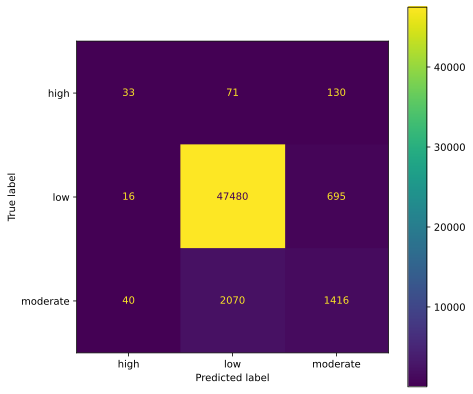

In [120]:
y = base['soil_erosion']
X=base[['Slope', 'scifo', 'sciom', 'MHH', 'NRH', 'NT', 'RT', 'CG',
       'CGCAWW', 'CGFAWW', 'CGSB', 'SGCT', 'SGCTCT', 'SGFAWW', 'SGSBWW', 'WW',
       'WWCT', 'WWCTCT', 'WWFA', 'WWWWCA', 'WWWWCT']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)
s = StandardScaler()
s.fit(X_train)
X_train_scaled=s.transform(X_train)
X_test_scaled= s.transform(X_test)
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train_scaled, y_train) 
y_predict = knn.predict(X_test_scaled)
print(metrics.accuracy_score(y_test, y_predict))
print(metrics.confusion_matrix(y_test, y_predict))
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(knn, X_test_scaled, y_test, ax=ax);